For this project, we adopted two different datasets, mentioned below.

ASL alphabet dataset : https://www.kaggle.com/datasets/grassknoted/asl-alphabet

Chatbot dataset : https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import DatasetDict
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig, GenerationConfig
from peft import LoraConfig, get_peft_model
from peft import PeftModel
from trl import SFTTrainer

c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chatbot Dataset - EDA and preprocessing

In [2]:
chatbot_df = pd.read_csv('Conversations_clean.csv')
#chatbot_df = chatbot_df.drop(columns = ['Unnamed: 0'])

In [3]:
chatbot_df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [4]:
chatbot_df.shape

(3725, 2)

#### EDA

EDA was performed by following a similar procedure to the one described by Singh (n.d.).

References:

Singh, H. (n.d.). Complete Guide to EDA on Text Data. Kaggle. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

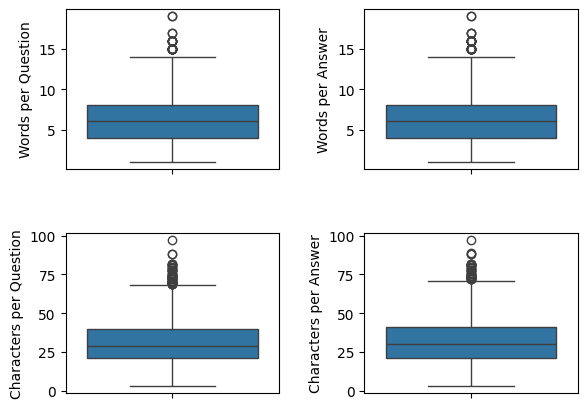

In [5]:
# Function to count the number of words in a sentence
def count_words(text):
    words = text.split() # extract the words from text
    num_words = len(words) # count the number of words
    return num_words

# Function to count the number of characters in a sentence
def count_characters(text):
    num_char = len(text) # count the number of chatacters
    return num_char

num_words_question = chatbot_df['question'].apply(count_words)
num_words_answer = chatbot_df['answer'].apply(count_words)
num_char_question = chatbot_df['question'].apply(count_characters)
num_char_answer = chatbot_df['answer'].apply(count_characters)

plt.subplot(2, 2, 1)
sns.boxplot(y = num_words_question)
plt.ylabel('Words per Question')
plt.subplot(2, 2, 2)
sns.boxplot(y = num_words_answer)
plt.ylabel('Words per Answer')
plt.subplot(2, 2, 3)
sns.boxplot(y = num_char_question)
plt.ylabel('Characters per Question')
plt.subplot(2, 2, 4)
sns.boxplot(y = num_char_answer)
plt.ylabel('Characters per Answer')
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.4, hspace = 0.4)
plt.savefig('Figure3.png')
plt.show()

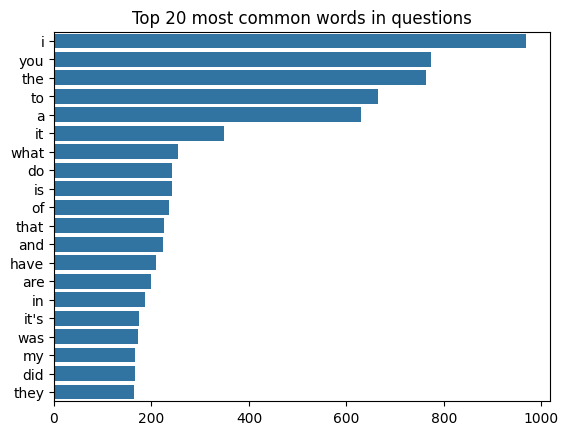

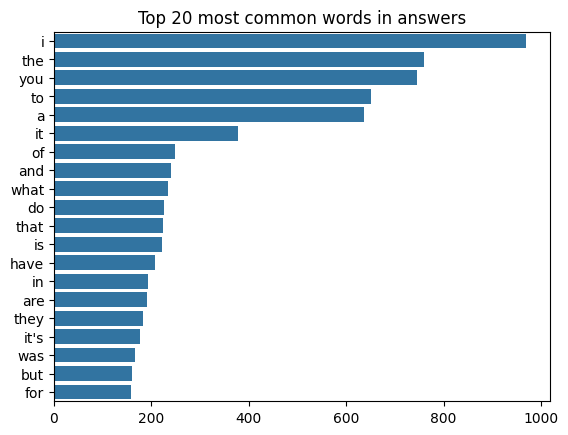

In [6]:
# Identify the most frequent words in the question/answer columns

# Function to get the list of words in a sentence
def list_words(text):
    words = text.split() # extract the words from text
    return words

# Function to get the top 20 most common words and their counts
def words_freq(mostcommon):
    words = []
    counts = []
    for word, count in mostcommon:
        words.append(word)
        counts.append(count)
    return words, counts

words_question = chatbot_df['question'].apply(list_words)
words_answer = chatbot_df['answer'].apply(list_words)
corpus_question = []
for jj in range(len(words_question)):
    corpus_question += words_question[jj] # all the words in all the questions
corpus_answer = []
for jj in range(len(words_answer)):
    corpus_answer += words_answer[jj] # all the words in all the answers
mostcommon_words_question = Counter(corpus_question).most_common(20) # 20 most common words in all the questions
mostcommon_words_answer = Counter(corpus_answer).most_common(20) # 20 most common words in all the answers
words_question, counts_question = words_freq(mostcommon_words_question) # top 20 most common words and their counts in questions
words_answer, counts_answer = words_freq(mostcommon_words_answer) # top 20 most common words and their counts in answers

sns.barplot(x = counts_question, y = words_question)
plt.title('Top 20 most common words in questions')
plt.show()

sns.barplot(x = counts_answer, y = words_answer)
plt.title('Top 20 most common words in answers')
plt.show()

#### Preprocessing

In order to replace contractions, we adopted the same procedure described in Replace apostrophe/short words in python (n.d.). 

References: 

Replace apostrophe/short words in python. (n.d.). Stack Overflow. Retrieved July 24, 2024, from https://owl.purdue.edu/owl/research_and_citation/apa_style/apa_formatting_and_style_guide/reference_list_electronic_sources.html

In [7]:
# List of common contractions 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# Function to replace contractions, remove punctuation and apply lowercase
def clear_text(text):
    for word in text.split(): # remove contractions and apply lowercase
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    return text

chatbot_df['question'] = chatbot_df['question'].apply(clear_text)
chatbot_df['answer'] = chatbot_df['answer'].apply(clear_text)
chatbot_df.head()

,question,answer
0,hi how are you doing,I am fine how about yourself
1,I am fine how about yourself,I am pretty good thanks for asking
2,I am pretty good thanks for asking,no problem so how have you been
3,no problem so how have you been,I have been great what about you
4,I have been great what about you,I have been good I am in school right now


In [8]:
# Tokenization
chatbot_df['token_question'] = chatbot_df['question'].apply(nltk.word_tokenize)
chatbot_df['token_answer'] = chatbot_df['answer'].apply(nltk.word_tokenize)
chatbot_df.head()

,question,answer,token_question,token_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right..."


In [9]:
# Lemmatization

# Function to obtain the right positional tagging prior to lemmatization
# Same function presented in Python – Lemmatization Approaches with Examples (n.d.)
def right_pos_tagging(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Obtain the right positional tagging prior to lemmatization
# Positional tags were modified as suggested by Python – Lemmatization Approaches with Examples (n.d.)

tokens = chatbot_df['token_question']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_question = new_tag_tokens

tokens = chatbot_df['token_answer']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_answer = new_tag_tokens

# Implement lemmatization on the tokens
# A procedure similar to the one described in Python – Lemmatization Approaches with Examples (n.d.) and by Kumar (2021) was applied

wnl = WordNetLemmatizer()
Lemmatization = []
for jj in range(len(tagged_token_question)):
    lemmatized_question = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_question[jj]:
        if tag is None:
            lemmatized_question.append(word)
        else:
            lemmatized_question.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_question)
chatbot_df['lem_question'] = Lemmatization

Lemmatization = []
for jj in range(len(tagged_token_answer)):
    lemmatized_answer = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_answer[jj]:
        if tag is None:
            lemmatized_answer.append(word)
        else:
            lemmatized_answer.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_answer)
chatbot_df['lem_answer'] = Lemmatization

chatbot_df.head()

# References
# Kumar, R. (2021, August 6). Natural Language Processing | Text Preprocessing | Spacy vs NLTK. Medium. https://medium.com/nerd-for-tech/natural-language-processing-text-preprocessing-spacy-vs-nltk-b70b734f5560
# Python – Lemmatization Approaches with Examples. (n.d.). Geeks for Geeks.  https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

,question,answer,token_question,token_answer,lem_question,lem_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]","[hi, how, be, you, do]","[I, be, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]","[I, be, fine, how, about, yourself]","[I, be, pretty, good, thanks, for, ask]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]","[I, be, pretty, good, thanks, for, ask]","[no, problem, so, how, have, you, be]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]","[no, problem, so, how, have, you, be]","[I, have, be, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right...","[I, have, be, great, what, about, you]","[I, have, be, good, I, be, in, school, right, ..."


## Google Gemma Fine Tuning

This section was created based on a combination of the following references.

References: 
https://www.datacamp.com/tutorial/fine-tuning-google-gemma
https://www.kaggle.com/code/ajinkyabhandare2002/fine-tune-flan-t5-base-for-chat-with-peft-lora

#### Import tokenizer and model

In [10]:
# Create a bits and bytes configuraiton to help handle precision and memory usage
bnbConfig = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [11]:
base_model_name = 'google/gemma-2-9b'
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, quantization_config=bnbConfig, device_map = 'auto')
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

Loading checkpoint shards: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]


#### Data preprocessing

In [12]:
# Initialize the data
data = chatbot_df.drop(columns = ['token_question', 'token_answer', 'lem_question', 'lem_answer'])
data

,question,answer
0,hi how are you doing,I am fine how about yourself
1,I am fine how about yourself,I am pretty good thanks for asking
2,I am pretty good thanks for asking,no problem so how have you been
3,no problem so how have you been,I have been great what about you
4,I have been great what about you,I have been good I am in school right now
...,...,...
3720,that has that is a good question maybe it has...,are you righthanded
3721,are you righthanded,yes all my life
3722,yes all my life,you are wearing out your right hand stop using...
3723,you are wearing out your right hand stop using...,but i do all my writing with my right hand


In [13]:
# Define training, validation, and testing data
data_train, data_val_test = train_test_split(data, test_size = 0.2, random_state = 100)
data_val, data_test = train_test_split(data_val_test, test_size = 0.5, random_state = 100)

# Convert the dataframes to a dataset objects
train_data = Dataset.from_pandas(data_train)
val_data = Dataset.from_pandas(data_val)
test_data = Dataset.from_pandas(data_test)
train_data = train_data.remove_columns("__index_level_0__")
val_data = val_data.remove_columns("__index_level_0__")
test_data = test_data.remove_columns("__index_level_0__")

# Create a directory of datasets
dataset = DatasetDict({
    "train": train_data,
    "val": val_data,
    "test": test_data,
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 2980
    })
    val: Dataset({
        features: ['question', 'answer'],
        num_rows: 372
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 373
    })
})


In [14]:
# Functions to tokenize questions and answers
# def tokenization(example):
#     inputs = tokenizer(example['question'], padding = True, truncation = True, return_tensors = 'pt').to('cuda')
#     example['inputs_ids'] = inputs
#     labels = tokenizer(example['answer'], padding = True, truncation = True, return_tensors = 'pt').to('cuda')
#     example['labels'] = labels
#     return example

def tokenization(example):
    example['input_ids'] = tokenizer(example["question"], padding=True, truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["answer"], padding=True, truncation=True, return_tensors="pt").input_ids
    return example

# Apply tokenizization to dataset
tokenized_dataset = dataset.map(tokenization, batched = True)
tokenized_dataset = tokenized_dataset.remove_columns(['question', 'answer'])

Map: 100%|██████████| 373/373 [00:00<00:00, 37274.26 examples/s]


#### Setup the PEFT/LoRA model for Fine-Tuning

In [15]:
peft_config = LoraConfig(
    r = 64, 
    lora_alpha = 16,
    lora_dropout = 0.1,
    bias = 'none',
    task_type = 'CASUAL_LM',
    target_modules = ['o_proj', 'q_proj', 'up_proj', 'v_proj', 'k_proj', 'down_proj', 'gate_proj']
)

#### Add LoRA adapter layers/prameters to the LLM model to be trained

In [16]:
peft_model = get_peft_model(base_model, peft_config)

#### Train PEFT Adapter

In [17]:
# Define training arguments
args=TrainingArguments(  # Arguments for training setup.
    per_device_train_batch_size=1,  # Batch size per device (e.g., GPU).
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating model weights.
    warmup_steps=5,  # Number of steps to gradually increase the learning rate at the beginning of training.
    max_steps=30,  # Total number of training steps to perform.
    learning_rate=2e-4,  # Learning rate for the optimizer.
    fp16=False,  # Whether to use 16-bit floating point precision for training. False means 32-bit is used.
    logging_steps=1,  # How often to log training information.
    output_dir="outputs",  # Directory where training outputs will be saved.
    optim="paged_adamw_8bit"  # The optimizer to use, with 8-bit precision for efficiency.
)

In [18]:
# Initialize the Trainer
trainer = SFTTrainer(
    model = peft_model, 
    peft_config = peft_config,
    args = args, 
    train_dataset = tokenized_dataset['train'], 
    eval_dataset = tokenized_dataset['val'],
    max_seq_length = 512,
    tokenizer = tokenizer, 
)

# Fine-tune the model
trainer.train()

c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\huggingface_hub\utils\_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\trl\trainer\sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\trl\trainer\sft_trainer.py:408: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is giv

{'loss': 11.5765, 'grad_norm': 21.324264526367188, 'learning_rate': 4e-05, 'epoch': 0.0}


  7%|▋         | 2/30 [00:04<01:04,  2.31s/it]

{'loss': 6.8666, 'grad_norm': 9.612833976745605, 'learning_rate': 8e-05, 'epoch': 0.0}


 10%|█         | 3/30 [00:06<00:51,  1.91s/it]

{'loss': 6.9756, 'grad_norm': 11.656783103942871, 'learning_rate': 0.00012, 'epoch': 0.0}


 13%|█▎        | 4/30 [00:07<00:45,  1.76s/it]

{'loss': 5.0074, 'grad_norm': 14.737255096435547, 'learning_rate': 0.00016, 'epoch': 0.01}


 17%|█▋        | 5/30 [00:09<00:41,  1.66s/it]

{'loss': 5.7117, 'grad_norm': 7.697540760040283, 'learning_rate': 0.0002, 'epoch': 0.01}


 20%|██        | 6/30 [00:10<00:35,  1.49s/it]

{'loss': 4.4296, 'grad_norm': 16.88793182373047, 'learning_rate': 0.000192, 'epoch': 0.01}


 23%|██▎       | 7/30 [00:11<00:32,  1.41s/it]

{'loss': 4.3726, 'grad_norm': 6.946990966796875, 'learning_rate': 0.00018400000000000003, 'epoch': 0.01}


 27%|██▋       | 8/30 [00:13<00:29,  1.35s/it]

{'loss': 3.4938, 'grad_norm': 4.207177639007568, 'learning_rate': 0.00017600000000000002, 'epoch': 0.01}


 30%|███       | 9/30 [00:14<00:27,  1.31s/it]

{'loss': 3.3888, 'grad_norm': 6.705206871032715, 'learning_rate': 0.000168, 'epoch': 0.01}


 33%|███▎      | 10/30 [00:15<00:25,  1.29s/it]

{'loss': 3.8445, 'grad_norm': 3.8925909996032715, 'learning_rate': 0.00016, 'epoch': 0.01}


 37%|███▋      | 11/30 [00:16<00:24,  1.27s/it]

{'loss': 3.9048, 'grad_norm': 4.944846153259277, 'learning_rate': 0.000152, 'epoch': 0.01}


 40%|████      | 12/30 [00:17<00:22,  1.26s/it]

{'loss': 3.0218, 'grad_norm': 3.4040021896362305, 'learning_rate': 0.000144, 'epoch': 0.02}


 43%|████▎     | 13/30 [00:19<00:21,  1.25s/it]

{'loss': 3.3545, 'grad_norm': 4.067464351654053, 'learning_rate': 0.00013600000000000003, 'epoch': 0.02}


 47%|████▋     | 14/30 [00:20<00:20,  1.26s/it]

{'loss': 3.1533, 'grad_norm': 2.2264420986175537, 'learning_rate': 0.00012800000000000002, 'epoch': 0.02}


 50%|█████     | 15/30 [00:21<00:18,  1.23s/it]

{'loss': 4.1129, 'grad_norm': 4.038586139678955, 'learning_rate': 0.00012, 'epoch': 0.02}


 53%|█████▎    | 16/30 [00:22<00:17,  1.26s/it]

{'loss': 2.4996, 'grad_norm': 2.3728187084198, 'learning_rate': 0.00011200000000000001, 'epoch': 0.02}


 57%|█████▋    | 17/30 [00:24<00:17,  1.34s/it]

{'loss': 2.5953, 'grad_norm': 2.6001904010772705, 'learning_rate': 0.00010400000000000001, 'epoch': 0.02}


 60%|██████    | 18/30 [00:25<00:16,  1.38s/it]

{'loss': 3.631, 'grad_norm': 2.4438605308532715, 'learning_rate': 9.6e-05, 'epoch': 0.02}


 63%|██████▎   | 19/30 [00:27<00:15,  1.39s/it]

{'loss': 3.5535, 'grad_norm': 2.7520904541015625, 'learning_rate': 8.800000000000001e-05, 'epoch': 0.03}


 67%|██████▋   | 20/30 [00:28<00:13,  1.40s/it]

{'loss': 3.8702, 'grad_norm': 3.336460828781128, 'learning_rate': 8e-05, 'epoch': 0.03}


 70%|███████   | 21/30 [00:30<00:12,  1.39s/it]

{'loss': 2.4537, 'grad_norm': 2.431959390640259, 'learning_rate': 7.2e-05, 'epoch': 0.03}


 73%|███████▎  | 22/30 [00:31<00:11,  1.38s/it]

{'loss': 2.9873, 'grad_norm': 2.9720544815063477, 'learning_rate': 6.400000000000001e-05, 'epoch': 0.03}


 77%|███████▋  | 23/30 [00:32<00:09,  1.36s/it]

{'loss': 2.8751, 'grad_norm': 3.308215856552124, 'learning_rate': 5.6000000000000006e-05, 'epoch': 0.03}


 80%|████████  | 24/30 [00:34<00:07,  1.33s/it]

{'loss': 2.9723, 'grad_norm': 3.215001344680786, 'learning_rate': 4.8e-05, 'epoch': 0.03}


 83%|████████▎ | 25/30 [00:35<00:06,  1.29s/it]

{'loss': 3.1087, 'grad_norm': 2.4506771564483643, 'learning_rate': 4e-05, 'epoch': 0.03}


 87%|████████▋ | 26/30 [00:36<00:05,  1.29s/it]

{'loss': 3.259, 'grad_norm': 2.65631365776062, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.03}


 90%|█████████ | 27/30 [00:37<00:03,  1.26s/it]

{'loss': 3.1167, 'grad_norm': 2.597785234451294, 'learning_rate': 2.4e-05, 'epoch': 0.04}


 93%|█████████▎| 28/30 [00:39<00:02,  1.25s/it]

{'loss': 2.6912, 'grad_norm': 2.688758373260498, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.04}


 97%|█████████▋| 29/30 [00:40<00:01,  1.24s/it]

{'loss': 3.6027, 'grad_norm': 2.8092777729034424, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.04}


100%|██████████| 30/30 [00:41<00:00,  1.22s/it]

{'loss': 4.2037, 'grad_norm': 3.8153886795043945, 'learning_rate': 0.0, 'epoch': 0.04}


100%|██████████| 30/30 [00:44<00:00,  1.48s/it]

{'train_runtime': 44.5514, 'train_samples_per_second': 2.694, 'train_steps_per_second': 0.673, 'train_loss': 4.021145955721537, 'epoch': 0.04}


TrainOutput(global_step=30, training_loss=4.021145955721537, metrics={'train_runtime': 44.5514, 'train_samples_per_second': 2.694, 'train_steps_per_second': 0.673, 'total_flos': 140299624163328.0, 'train_loss': 4.021145955721537, 'epoch': 0.040268456375838924})

#### Save the fine-tuned model

In [19]:
new_model_name = 'fine-tuned_model'
trainer.model.save_pretrained(new_model_name)

#### Inference

In [20]:
# final_model = PeftModel.from_pretrained(base_model_name, new_model_name)

# def generate_answer(question):
    
#     # Model inputs
#     inputs = tokenizer(question, padding = True, truncation = True, return_tensors = 'pt').to('cuda')
    
#     # Model outputs
#     outputs = final_model.generate(**inputs, max_length = 500, num_return_sequences = 1)
    
#     # Final text
#     final_text = tokenizer.decode(outputs[0], skip_special_tokens = True)
    
#     return final_text

# # Example usage
# question = "Hi, how are you?"
# answer = generate_answer(clear_text(question))
# print(answer)

In [21]:
final_model = PeftModel.from_pretrained(base_model, new_model_name)

question = "Where are you from?"

inputs = tokenizer(question, return_tensors = 'pt').input_ids
input_ids = inputs.to('cuda')

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(peft_model_text_output)

Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the city of the sun.Where are you from?

I am from the
